In [7]:
import warnings

warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

In [8]:
# Read the data
df = pd.read_pickle("../data/survey.pkl")

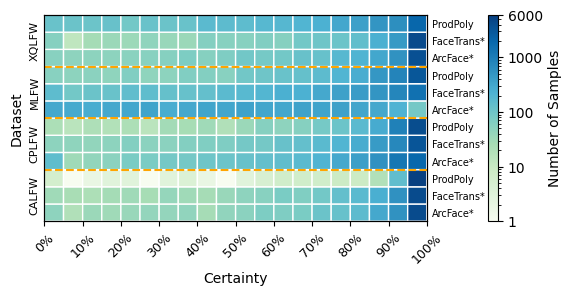

In [9]:
mydf = df[(df.model.isin(["ProdPoly", "FaceTrans*", "ArcFace*"])) & (~df.dataset.isin(["base", "lfw", "sllfw"]))]

# Plot the Scores Histogram for all Datasets and Models
NUM_BINS = 20

bins = pd.cut(mydf.certainty, bins=np.linspace(-0.001, 1.0, NUM_BINS + 1))

counts = mydf.groupby(["dataset", "model", bins]).size().reset_index(name="count").sort_values(by=["dataset", "model", "certainty"])

val_list = [list(group["count"]) for _, group in counts.groupby(["dataset", "model"])]

# Figure
fig, ax = plt.subplots(figsize=(6, 3))
c = ax.pcolor(val_list, cmap="GnBu", edgecolors="w", linewidths=1, norm="log")

# add line between datasets
for i in range(1, len(counts.dataset.unique())):
    ax.axhline(y=3 * i, color="orange", linewidth=1.5, linestyle="--")


# X-Axis
ax.set_xticks(np.linspace(0, 20, 11))
ax.set_xticklabels([f"{val:.0%}" for val in np.linspace(0, 1, 11)])
ax.set_xlabel("Certainty")
plt.xticks(fontsize=9, rotation=45)

# First Y-Axis (DATASETS)
ax.set_yticks(np.arange(1.5, 3 * len(counts.dataset.unique()), 3))
ax.set_yticklabels([elem.upper() for elem in counts.dataset.unique()], minor=False, fontsize=8)
ax.set_ylabel("Dataset")
plt.yticks(rotation=90, va="center")
ax.tick_params(axis="y", which="both", length=0)

# Second Y-Axis (MODELS)
ax2 = ax.twinx()
ax2.set_ylim([0, 12])
ax2.set_yticks(np.arange(0.5, 4 * len(counts.model.unique()) + 0.5, 1))
ax2.set_yticklabels((counts.model.unique().tolist() * 4), minor=False)
ax2.tick_params(labelsize=7)
ax2.tick_params(axis="y", which="both", length=0)

fig.tight_layout()
# Colorbar
cbar = fig.colorbar(c, ax=ax, anchor=(0.6, 0.0))
cbar.set_label("Number of Samples")
cbar.set_ticks([1, 10, 100, 1000, 6000])
cbar.set_ticklabels([1, 10, 100, 1000, 6000])

plt.savefig("../figures/scores_histogram.pdf", bbox_inches="tight")

In [10]:
# For each dataset (except lfw and sllfw and base), print the number of true and false labels of model: "Human"
dfh = df[df.model == "Human"]

# Get labels for all datasets
cnt_true = dfh.groupby("dataset").label.sum().rename("#True")
cnt = dfh.groupby("dataset").label.count().rename("#Total")
cnt_false = (cnt - cnt_true).rename("#False")
table = pd.concat([cnt_true, cnt_false, cnt], axis=1)

# add a row to the bottom of the table with sums
table.loc["Total"] = table.sum()

# Print the number of true and false labels in one table
print(table.to_markdown())
table.to_clipboard()

# Print the percentage of True labels
print(table.div(table.iloc[:, -1], axis=0).to_markdown(floatfmt=".2%"))
table.div(table.iloc[:, -1], axis=0).to_clipboard()

| dataset   |   #True |   #False |   #Total |
|:----------|--------:|---------:|---------:|
| base      |    1200 |     1200 |     2400 |
| calfw     |     322 |      362 |      684 |
| cplfw     |     617 |      768 |     1385 |
| mlfw      |    1715 |     1846 |     3561 |
| xqlfw     |     815 |     1000 |     1815 |
| Total     |    4669 |     5176 |     9845 |
| dataset   |   #True |   #False |   #Total |
|:----------|--------:|---------:|---------:|
| base      |  50.00% |   50.00% |  100.00% |
| calfw     |  47.08% |   52.92% |  100.00% |
| cplfw     |  44.55% |   55.45% |  100.00% |
| mlfw      |  48.16% |   51.84% |  100.00% |
| xqlfw     |  44.90% |   55.10% |  100.00% |
| Total     |  47.43% |   52.57% |  100.00% |


dataset: calfw Amount of Pairs: 534
dataset: cplfw Amount of Pairs: 1235
dataset: mlfw Amount of Pairs: 3411
dataset: xqlfw Amount of Pairs: 1666


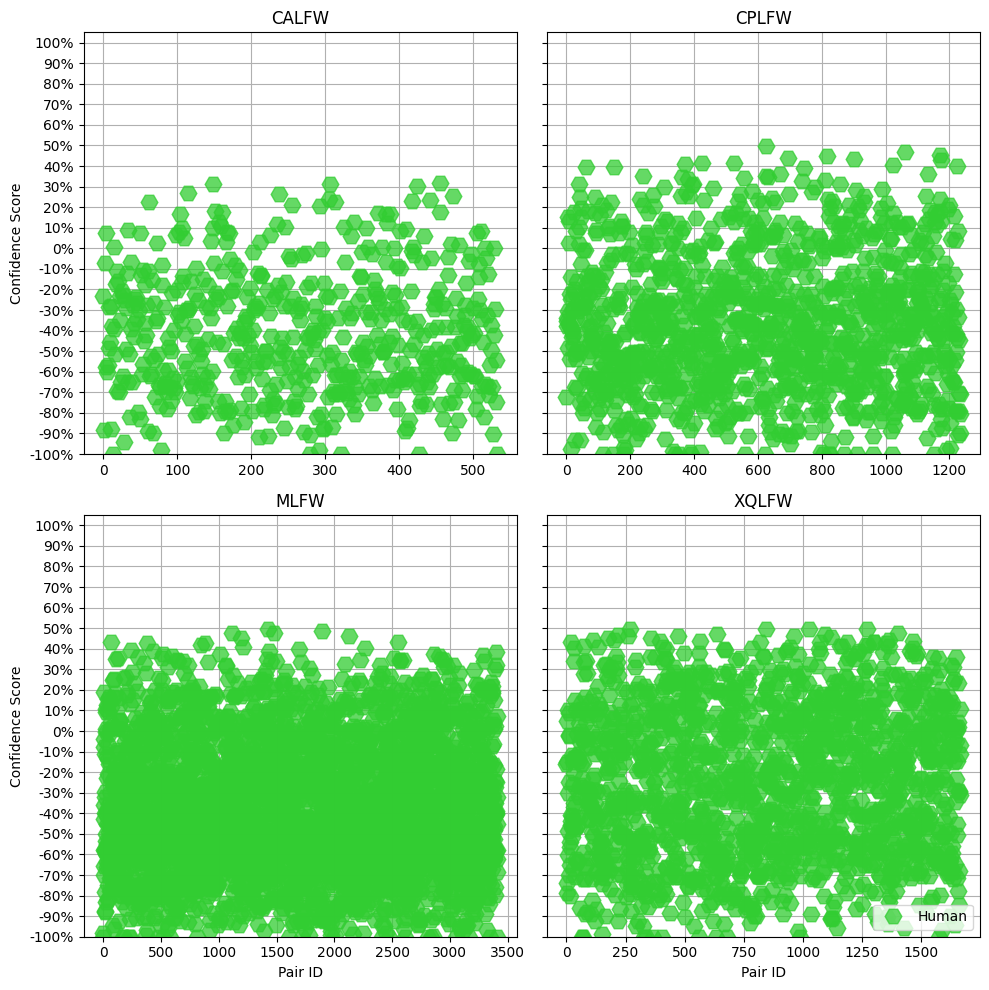

In [11]:
# Plot Certainty for each pair_id
mydf = df[(df.model.isin(["AIMin", "Human"])) & (~df.dataset.isin(["lfw", "sllfw", "base"]))]

# Delete rows where in column "model" is AIMean and there exists no row with same pair_id&dataset and model "Human"
mydf = mydf[~((mydf.model == "AIMin") & (~mydf.pair_id.isin(mydf[(mydf.model == "Human")].pair_id)))]

result = mydf.pivot(index=["dataset", "pair_id"], columns="model", values="certainty").dropna()

# Delete rows where for model AIMin the certainty is above 0.5
result = result[result.AIMin < 0.5]

# Make a plot for each Dataset with the certainty of Human
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=False, sharey=True)
for i, dataset in enumerate(result.index.get_level_values(0).unique()):
    print(f"dataset: {dataset} Amount of Pairs: {len(result.loc[dataset].AIMin)}")
    ax[i // 2, i % 2].plot(
        result.loc[dataset].AIMin.values - result.loc[dataset].Human.values, "H", color="limegreen", linewidth=1, alpha=0.75, markersize=12
    )
    # ax[i // 2, i % 2].plot(result.loc[dataset].AIMin.values, "H", color="red", linewidth=1, alpha=0.75, markersize=12)
    ax[i // 2, i % 2].set_title(dataset.upper())
    ax[i // 2, i % 2].set_ylim([-0.05, 1.05])
    ax[i // 2, i % 2].set_yticks(np.linspace(-1, 1.0, 21))
    ax[i // 2, i % 2].set_yticklabels([f"{val:.0%}" for val in np.linspace(-1, 1.0, 21)])
    ax[i // 2, i % 2].grid("on")
ax[1, 1].set_xlabel("Pair ID")
ax[1, 0].set_xlabel("Pair ID")
ax[0, 0].set_ylabel("Confidence Score")
ax[1, 0].set_ylabel("Confidence Score")
fig.tight_layout()
# add legend
plt.legend(["Human", "AIMin"], loc="lower right")

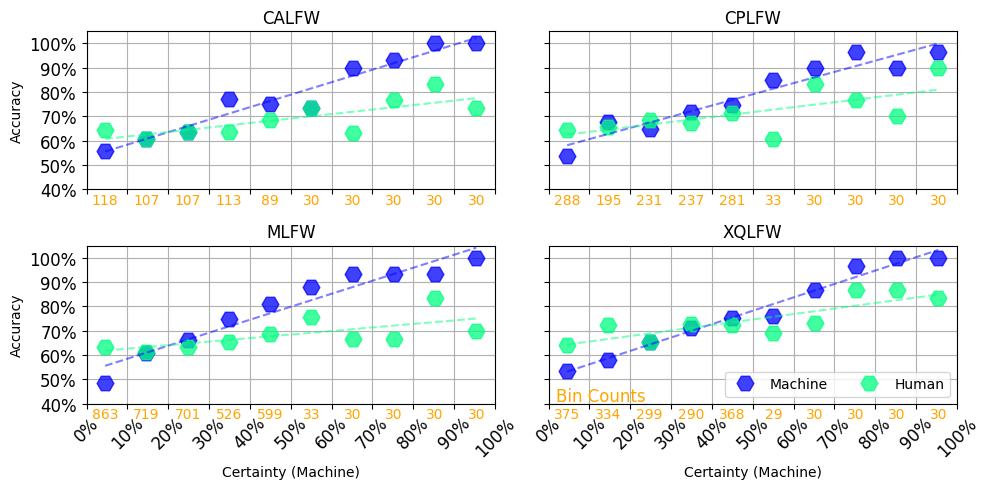

In [12]:
# Calculate mean accuracy for each certainty bin for each dataset and model (based on certainty of AIMin)
model = "AIMin"

NUM_BINS = 10

# Plot Certainty for each pair_id
mydf = df[(df.model.isin([model, "Human"])) & (~df.dataset.isin(["lfw", "sllfw", "base"]))]

# Delete rows where in column "model" is AIMean and there exists no row with same pair_id&dataset and model "Human"
mydf = mydf[~((mydf.model == model) & (~mydf.pair_id.isin(mydf[(mydf.model == "Human")].pair_id)))]

result = mydf.pivot(index=["dataset", "pair_id"], columns="model", values=["certainty", "correct"]).dropna()

bins = pd.cut(result["certainty"][model], bins=np.linspace(-0.001, 1.0, NUM_BINS + 1))

accs = result["correct"].groupby(["dataset", bins]).agg(["mean", "std", "count"])

# Plot the accuracies for each bin for each dataset and model (based on certainty of AIMin)
colors = cm.winter(np.linspace(0, 1, 2))
fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True)
for i, dataset in enumerate(accs.index.get_level_values(0).unique()):
    ax[i // 2, i % 2].plot(
        np.linspace(0.0, 1.0, len(accs.loc[dataset][model]["mean"])),
        accs.loc[dataset][model]["mean"],
        "H",
        color=colors[0],
        linewidth=1,
        alpha=0.75,
        markersize=12,
    )
    ax[i // 2, i % 2].plot(
        np.linspace(0.0, 1.0, len(accs.loc[dataset].Human["mean"])),
        accs.loc[dataset].Human["mean"],
        "H",
        color=colors[1],
        linewidth=1,
        alpha=0.75,
        markersize=12,
    )
    # Add text to the plot with counts for each bin
    for j, count in enumerate(accs.loc[dataset][model]["count"]):
        ax[i // 2, i % 2].text(
            np.linspace(0, 1.0, len(accs.loc[dataset][model]))[j], 0.34, count, fontsize=10, color="orange", horizontalalignment="center"
        )
    # Add std to the plot for each bin
    # ax[i // 2, i % 2].fill_between(np.linspace(0.0, 1.0, len(accs.loc[dataset][model]["mean"])), accs.loc[dataset][model]["mean"] - accs.loc[dataset][model]["std"], accs.loc[dataset][model]["mean"] + accs.loc[dataset][model]["std"], color=colors[0], alpha=0.2)
    # ax[i // 2, i % 2].fill_between(np.linspace(0.0, 1.0, len(accs.loc[dataset].Human["mean"])), accs.loc[dataset].Human["mean"] - accs.loc[dataset].Human["std"], accs.loc[dataset].Human["mean"] + accs.loc[dataset].Human["std"], color=colors[1], alpha=0.2)

    # Add trendlines
    z = np.polyfit(np.linspace(0.0, 1.0, len(accs.loc[dataset][model]["mean"])), accs.loc[dataset][model]["mean"].astype(float), 1)
    p = np.poly1d(z)
    ax[i // 2, i % 2].plot(
        np.linspace(0.0, 1.0, len(accs.loc[dataset][model]["mean"])),
        p(np.linspace(0.0, 1.0, len(accs.loc[dataset][model]["mean"]))),
        color=colors[0],
        alpha=0.5,
        linestyle="--",
    )
    z = np.polyfit(np.linspace(0.0, 1.0, len(accs.loc[dataset].Human["mean"])), accs.loc[dataset].Human["mean"].astype(float), 1)
    p = np.poly1d(z)
    ax[i // 2, i % 2].plot(
        np.linspace(0.0, 1.0, len(accs.loc[dataset].Human["mean"])),
        p(np.linspace(0.0, 1.0, len(accs.loc[dataset].Human["mean"]))),
        color=colors[1],
        alpha=0.5,
        linestyle="--",
    )

    ax[i // 2, i % 2].set_title(dataset.upper())
    ax[i // 2, i % 2].set_xlim([-0.05, 1.05])
    ax[i // 2, i % 2].set_ylim([0.4, 1.05])
    ax[i // 2, i % 2].set_xticks(np.linspace(-0.05, 1.05, 11))
    ax[i // 2, i % 2].set_xticklabels([f"{val:.0%}" for val in np.linspace(0.0, 1.0, 11)], fontsize=12, rotation=45)
    ax[i // 2, i % 2].set_yticks(np.linspace(0.4, 1.0, 7))
    ax[i // 2, i % 2].set_yticklabels([f"{val:.0%}" for val in np.linspace(0.4, 1.0, 7)], fontsize=12)
    ax[i // 2, i % 2].grid("on")

ax[1, 1].set_xlabel("Certainty (Machine)")
ax[1, 0].set_xlabel("Certainty (Machine)")
ax[0, 0].set_ylabel("Accuracy")
ax[1, 0].set_ylabel("Accuracy")
fig.tight_layout()

# Make a text in orange with "Bin Counts"
plt.text(-0.03, 0.41, "Bin Counts", color="orange", fontsize=12)

# add legend
ax[1, 1].legend(["Machine", "Human"], loc="lower right", ncols=2)

# save
plt.savefig("../figures/scores_accuracy.pdf", bbox_inches="tight")

In [13]:
# FUSION
model = "ProdPoly"
MAX_CERTAINTY = 0.35
MIN_CERTAINTY = 0.2
CERTAINTY_DIFF = 0.05

results = []
# Do for each Dataset
for dataset in ["mlfw", "xqlfw", "calfw", "cplfw"]:
    mydf = df[(df.model.isin([model, "Human"])) & (df.dataset == dataset)]
    result = mydf.pivot(index="pair_id", columns="model", values=["certainty", "correct"])
    filter = (
        (result["certainty"][model] < MAX_CERTAINTY)
        & (result["certainty"]["Human"] - result["certainty"][model] > CERTAINTY_DIFF)
        & (result["certainty"]["Human"] != np.nan)
        & (result["certainty"]["Human"] > MIN_CERTAINTY)
    )

    # Human Predictions
    h = pd.DataFrame(result[filter]["correct"]["Human"].rename("correct").astype(float)).reset_index()
    cnt = len(h) / 6000
    # Machine Predictions
    m = pd.DataFrame(result[~filter]["correct"][model].rename("correct").astype(float)).reset_index()
    # Join
    acc_join = pd.concat([h, m]).correct.mean()
    params = {"MAX_CERTAINTY": MAX_CERTAINTY, "MIN_CERTAINTY": MIN_CERTAINTY, "CERTAINTY_DIFF": CERTAINTY_DIFF}
    # Add results to list
    results.append({"dataset": dataset, "model": "Fusion", "acc": acc_join, "cnt": cnt, **params})
    results.append(
        {"dataset": dataset, "model": model, "acc": result["correct"][model].mean(), "cnt": len(result["correct"][model]) / 6000}
    )

# Print Results
print(pd.DataFrame(results).groupby(["dataset", "model"]).sum().to_markdown(floatfmt=".2%"))
pd.DataFrame(results).groupby(["dataset", "model"]).sum().to_clipboard()

|                       |    acc |     cnt |   MAX_CERTAINTY |   MIN_CERTAINTY |   CERTAINTY_DIFF |
|:----------------------|-------:|--------:|----------------:|----------------:|-----------------:|
| ('calfw', 'Fusion')   | 96.12% |   0.27% |          35.00% |          20.00% |            5.00% |
| ('calfw', 'ProdPoly') | 96.03% | 100.00% |           0.00% |           0.00% |            0.00% |
| ('cplfw', 'Fusion')   | 92.77% |   1.93% |          35.00% |          20.00% |            5.00% |
| ('cplfw', 'ProdPoly') | 92.75% | 100.00% |           0.00% |           0.00% |            0.00% |
| ('mlfw', 'Fusion')    | 91.43% |   5.08% |          35.00% |          20.00% |            5.00% |
| ('mlfw', 'ProdPoly')  | 91.30% | 100.00% |           0.00% |           0.00% |            0.00% |
| ('xqlfw', 'Fusion')   | 88.03% |   9.27% |          35.00% |          20.00% |            5.00% |
| ('xqlfw', 'ProdPoly') | 86.90% | 100.00% |           0.00% |           0.00% |            0.00% |


In [14]:
# Make a Parameter Sweep for MAX_CERTAINTY, MIN_CERTAINTY, CERTAINTY_DIFF
import itertools
import time
import tqdm

STEPS = 1
all_params = list(itertools.product(np.linspace(0.37, 0.37, STEPS), np.linspace(0.11, 0.11, STEPS), np.linspace(0.05, 0.05, STEPS)))

for model in ["ArcFace*", "FaceTrans*", "ProdPoly"]:
    results = []
    # Do for each Dataset
    for dataset in ["mlfw", "xqlfw", "calfw", "cplfw"]:
        mydf = df[(df.model.isin([model, "Human"])) & (df.dataset == dataset)]
        result = mydf.pivot(index="pair_id", columns="model", values=["certainty", "correct"])

        tmp = []
        # Do for each combination of parameters
        for MAX_CERTAINTY, MIN_CERTAINTY, CERTAINTY_DIFF in tqdm.tqdm(all_params, leave=False):
            filter = (
                (result["certainty"][model] < MAX_CERTAINTY)
                & (result["certainty"]["Human"] - result["certainty"][model] > CERTAINTY_DIFF)
                & (result["certainty"]["Human"] != np.nan)
                & (result["certainty"]["Human"] > MIN_CERTAINTY)
            )

            # Human Predictions
            h = pd.DataFrame(result[filter]["correct"]["Human"].rename("correct").astype(float)).reset_index()
            cnt = len(h) / 6000

            # Machine Predictions
            m = pd.DataFrame(result[~filter]["correct"][model].rename("correct").astype(float)).reset_index()

            # Join
            acc_join = pd.concat([h, m]).correct.mean()

            params = {"MAX_CERTAINTY": MAX_CERTAINTY, "MIN_CERTAINTY": MIN_CERTAINTY, "CERTAINTY_DIFF": CERTAINTY_DIFF}

            # add params, cnt, and acc_join to a tmp list
            tmp.append({"dataset": dataset, "model": "Fusion", "acc": acc_join, "cnt": cnt, **params})

        # Find best parameters
        bst = pd.DataFrame(tmp).sort_values("acc", ascending=False).iloc[0]

        # Add results to list
        results.append(bst.to_dict())
        results.append(
            {"dataset": dataset, "model": model, "acc": result["correct"][model].mean(), "cnt": len(result["correct"][model]) / 6000}
        )

    # Print Results
    print(pd.DataFrame(results).groupby(["dataset", "model"]).sum().unstack().T.to_markdown(floatfmt=".2%"))
    pd.DataFrame(results).groupby(["dataset", "model"]).sum().to_clipboard()

    time.sleep(5)

|                                |   calfw |   cplfw |    mlfw |   xqlfw |
|:-------------------------------|--------:|--------:|--------:|--------:|
| ('acc', 'ArcFace*')            |  93.85% |  88.37% |  73.53% |  93.27% |
| ('acc', 'Fusion')              |  94.03% |  88.83% |  75.88% |  93.65% |
| ('cnt', 'ArcFace*')            | 100.00% | 100.00% | 100.00% | 100.00% |
| ('cnt', 'Fusion')              |   4.02% |   7.83% |  31.18% |   4.28% |
| ('MAX_CERTAINTY', 'ArcFace*')  |   0.00% |   0.00% |   0.00% |   0.00% |
| ('MAX_CERTAINTY', 'Fusion')    |  37.00% |  37.00% |  37.00% |  37.00% |
| ('MIN_CERTAINTY', 'ArcFace*')  |   0.00% |   0.00% |   0.00% |   0.00% |
| ('MIN_CERTAINTY', 'Fusion')    |  11.00% |  11.00% |  11.00% |  11.00% |
| ('CERTAINTY_DIFF', 'ArcFace*') |   0.00% |   0.00% |   0.00% |   0.00% |
| ('CERTAINTY_DIFF', 'Fusion')   |   5.00% |   5.00% |   5.00% |   5.00% |


|                                  |   calfw |   cplfw |    mlfw |   xqlfw |
|:---------------------------------|--------:|--------:|--------:|--------:|
| ('acc', 'FaceTrans*')            |  94.93% |  91.58% |  85.63% |  95.12% |
| ('acc', 'Fusion')                |  94.93% |  91.73% |  85.70% |  95.28% |
| ('cnt', 'FaceTrans*')            | 100.00% | 100.00% | 100.00% | 100.00% |
| ('cnt', 'Fusion')                |   3.12% |   5.18% |  12.97% |   2.87% |
| ('MAX_CERTAINTY', 'FaceTrans*')  |   0.00% |   0.00% |   0.00% |   0.00% |
| ('MAX_CERTAINTY', 'Fusion')      |  37.00% |  37.00% |  37.00% |  37.00% |
| ('MIN_CERTAINTY', 'FaceTrans*')  |   0.00% |   0.00% |   0.00% |   0.00% |
| ('MIN_CERTAINTY', 'Fusion')      |  11.00% |  11.00% |  11.00% |  11.00% |
| ('CERTAINTY_DIFF', 'FaceTrans*') |   0.00% |   0.00% |   0.00% |   0.00% |
| ('CERTAINTY_DIFF', 'Fusion')     |   5.00% |   5.00% |   5.00% |   5.00% |


|                                |   calfw |   cplfw |    mlfw |   xqlfw |
|:-------------------------------|--------:|--------:|--------:|--------:|
| ('acc', 'Fusion')              |  96.13% |  92.82% |  91.35% |  88.05% |
| ('acc', 'ProdPoly')            |  96.03% |  92.75% |  91.30% |  86.90% |
| ('cnt', 'Fusion')              |   0.28% |   2.08% |   5.42% |  10.08% |
| ('cnt', 'ProdPoly')            | 100.00% | 100.00% | 100.00% | 100.00% |
| ('MAX_CERTAINTY', 'Fusion')    |  37.00% |  37.00% |  37.00% |  37.00% |
| ('MAX_CERTAINTY', 'ProdPoly')  |   0.00% |   0.00% |   0.00% |   0.00% |
| ('MIN_CERTAINTY', 'Fusion')    |  11.00% |  11.00% |  11.00% |  11.00% |
| ('MIN_CERTAINTY', 'ProdPoly')  |   0.00% |   0.00% |   0.00% |   0.00% |
| ('CERTAINTY_DIFF', 'Fusion')   |   5.00% |   5.00% |   5.00% |   5.00% |
| ('CERTAINTY_DIFF', 'ProdPoly') |   0.00% |   0.00% |   0.00% |   0.00% |
